# Simulação TFG - UNIFEI
Marcelo Rovai 30.11.2020

## Libraries

In [1]:
import time
import requests
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import tensorflow as tf
from sklearn import preprocessing

In [2]:
from tensorflow.keras import backend as K
from tensorflow.keras import callbacks 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation  
from tensorflow.keras.layers import Dense, BatchNormalization
from tensorflow.keras.optimizers import Adam

In [3]:
from tensorflow.keras.metrics import categorical_crossentropy 
from tensorflow.keras.utils import plot_model
from tensorflow.keras import optimizers
from tensorflow.keras.utils import to_categorical 

## Definição de Constantes

In [4]:
# Flag para remocao das colunas correlacionadas.
CLEAN_DATASET = True

# Flag para decisao de qual versao do dataset usar
DATASET_COMPLETO = False
# Caminho para o dataset
# Endereco para download: http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
# Backup: http://web.archive.org/web/*/http://kdd.ics.uci.edu/databases/kddcup99/kddcup99.html
if DATASET_COMPLETO:
    DATASET_PATH = "./data//kddcup.data" # Treino 98%, Validacao 1%, Teste 1%
    # https://stackoverflow.com/a/13613316
    TRAIN_PERCENTAGE = 0.98 
    VALIDATION_PERCENTAGE = 0.01
    TEST_PERCENTAGE = 0.01 
else:
    DATASET_PATH = "./data/kddcup.data_10_percent"
    # Treino 80%, Validacao 10%, Teste 10%
    TRAIN_PERCENTAGE = 0.8
    VALIDATION_PERCENTAGE = 0.1 
    TEST_PERCENTAGE = 0.1

In [5]:
## Threshold de correlacao para exclusao das colunas do dataset
CORRCOEF_THRESHOLD = 0.5

## Ignora os warnings de divisao por NaN
np.seterr(divide='ignore', invalid='ignore')

{'divide': 'warn', 'over': 'warn', 'under': 'ignore', 'invalid': 'warn'}

In [6]:
EPOCHS = 200 # Quantas vezes os dados serao corridos completamente 
BATCH_SIZE = 1024 # Quantas linhas do dataset serao lidas por vez
SHUFFLE = True # Mistura os dados antes do treino
VERBOSE = 1 # 0 - Desativa os logs durante o treino, 1 - Imprime os logs durante o treino
LEARNING_RATE = 0.01 # Taxa de aprendizado 
ACTIVATION_FN = "relu" # Funcao de ativacao

## Tipos de ataques 

In [7]:
attack_types = 'https://archive.ics.uci.edu/ml/machine-learning-databases/kddcup99-mld/training_attack_types'
types = requests.get(attack_types)
print(types.text)

back dos
buffer_overflow u2r
ftp_write r2l
guess_passwd r2l
imap r2l
ipsweep probe
land dos
loadmodule u2r
multihop r2l
neptune dos
nmap probe
perl u2r
phf r2l
pod dos
portsweep probe
rootkit u2r
satan probe
smurf dos
spy r2l
teardrop dos
warezclient r2l
warezmaster r2l




In [8]:
# Target types data extraction
attack_dict = {}
types_text_split = types.text.split()
for idx in range(0, len(types_text_split)):
    if idx < len(types_text_split) -1:
        attack_dict[types_text_split[idx]] = types_text_split[idx+1]
attack_dict['normal'] = 'normal'
attack_dict

{'back': 'dos',
 'dos': 'warezclient',
 'buffer_overflow': 'u2r',
 'u2r': 'satan',
 'ftp_write': 'r2l',
 'r2l': 'warezmaster',
 'guess_passwd': 'r2l',
 'imap': 'r2l',
 'ipsweep': 'probe',
 'probe': 'smurf',
 'land': 'dos',
 'loadmodule': 'u2r',
 'multihop': 'r2l',
 'neptune': 'dos',
 'nmap': 'probe',
 'perl': 'u2r',
 'phf': 'r2l',
 'pod': 'dos',
 'portsweep': 'probe',
 'rootkit': 'u2r',
 'satan': 'probe',
 'smurf': 'dos',
 'spy': 'r2l',
 'teardrop': 'dos',
 'warezclient': 'r2l',
 'warezmaster': 'r2l',
 'normal': 'normal'}

## Dataset 

In [9]:
ls ./data

kddcup.data             kddcup.data_10_percent


In [10]:
# Nome das colunas do dataset
column_names = [
    "duration",
    "protocol_type",
    "service",
    "flag",
    "src_bytes",
    "dst_bytes",
    "land",
    "wrong_fragment",
    "urgent",
    "hot",
    "num_failed_logins",
    "logged_in",
    "num_compromised",
    "root_shell",
    "su_attempted",
    "num_root",
    "num_file_creations",
    "num_shells",
    "num_access_files",
    "num_outbound_cmds",
    "is_host_login",
    "is_guest_login",
    "count",
    "srv_count",
    "serror_rate",
    "srv_serror_rate",
    "rerror_rate ",
    "srv_rerror_rate",
    "same_srv_rate",
    "diff_srv_rate",
    "srv_diff_host_rate",
    "dst_host_count",
    "dst_host_srv_count",
    "dst_host_same_srv_rate",
    "dst_host_diff_srv_rate",
    "dst_host_same_src_port_rate",
    "dst_host_srv_diff_host_rate",
    "dst_host_serror_rate",
    "dst_host_srv_serror_rate",
    "dst_host_rerror_rate",
    "dst_host_srv_rerror_rate",
    "attack",
]

In [11]:
# Leitura do dataset
dataset = pd.read_csv(DATASET_PATH, header=None, names=column_names)
dataset.shape

(494021, 42)

In [12]:
dataset.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.


In [13]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 494021 entries, 0 to 494020
Data columns (total 42 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   duration                     494021 non-null  int64  
 1   protocol_type                494021 non-null  object 
 2   service                      494021 non-null  object 
 3   flag                         494021 non-null  object 
 4   src_bytes                    494021 non-null  int64  
 5   dst_bytes                    494021 non-null  int64  
 6   land                         494021 non-null  int64  
 7   wrong_fragment               494021 non-null  int64  
 8   urgent                       494021 non-null  int64  
 9   hot                          494021 non-null  int64  
 10  num_failed_logins            494021 non-null  int64  
 11  logged_in                    494021 non-null  int64  
 12  num_compromised              494021 non-null  int64  
 13 

### Definição variável target

In [14]:
dataset.attack.value_counts()

smurf.              280790
neptune.            107201
normal.              97278
back.                 2203
satan.                1589
ipsweep.              1247
portsweep.            1040
warezclient.          1020
teardrop.              979
pod.                   264
nmap.                  231
guess_passwd.           53
buffer_overflow.        30
land.                   21
warezmaster.            20
imap.                   12
rootkit.                10
loadmodule.              9
ftp_write.               8
multihop.                7
phf.                     4
perl.                    3
spy.                     2
Name: attack, dtype: int64

In [15]:
# map actual type to another column called 'target_type'
dataset['target_type'] = dataset.attack.apply(lambda x : attack_dict[x[0:-1]] )
dataset.target_type.value_counts()

dos       391458
normal     97278
probe       4107
r2l         1126
u2r           52
Name: target_type, dtype: int64

## Dataset Exploration 

### Identificando dados numéricos e categóricos 

In [16]:
numeric_cols = dataset._get_numeric_data().columns
numeric_cols

Index(['duration', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment',
       'urgent', 'hot', 'num_failed_logins', 'logged_in', 'num_compromised',
       'root_shell', 'su_attempted', 'num_root', 'num_file_creations',
       'num_shells', 'num_access_files', 'num_outbound_cmds', 'is_host_login',
       'is_guest_login', 'count', 'srv_count', 'serror_rate',
       'srv_serror_rate', 'rerror_rate ', 'srv_rerror_rate', 'same_srv_rate',
       'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count',
       'dst_host_srv_count', 'dst_host_same_srv_rate',
       'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate',
       'dst_host_srv_diff_host_rate', 'dst_host_serror_rate',
       'dst_host_srv_serror_rate', 'dst_host_rerror_rate',
       'dst_host_srv_rerror_rate'],
      dtype='object')

In [17]:
categorical_cols = list(set(dataset.columns)-set(numeric_cols))
categorical_cols

['service', 'flag', 'attack', 'protocol_type', 'target_type']

### Identificando dados binários (0 e 1)

In [18]:
def identify_binary_cols(data):
    binary_cols = []
    for col in numeric_cols:
        if len(data[col].unique()) <= 2:
            result = []
            s = data[col].value_counts()
            t = float(len(data[col]))
            for v in s.index:
                result.append("{}({}%)".format(v,round(100*(s[v]/t),1)))
            print("{} - [{}]".format(col, " , ".join(result)))
            binary_cols.append(col)
    return binary_cols

In [19]:
binary_cols = identify_binary_cols(dataset)

land - [0(100.0%) , 1(0.0%)]
logged_in - [0(85.2%) , 1(14.8%)]
root_shell - [0(100.0%) , 1(0.0%)]
num_outbound_cmds - [0(100.0%)]
is_host_login - [0(100.0%)]
is_guest_login - [0(99.9%) , 1(0.1%)]


In [20]:
dataset.is_host_login.value_counts()

0    494021
Name: is_host_login, dtype: int64

In [21]:
dataset.num_outbound_cmds.value_counts()

0    494021
Name: num_outbound_cmds, dtype: int64

### Deletar colunas que não possuem variaçoes

In [22]:
del dataset['is_host_login']
del dataset['num_outbound_cmds']

In [23]:
binary_cols.remove('is_host_login')
binary_cols.remove('num_outbound_cmds')
binary_cols

['land', 'logged_in', 'root_shell', 'is_guest_login']

In [24]:
# definir dados binários como categóricos 
for col in binary_cols:
    categorical_cols.append(col)
categorical_cols

['service',
 'flag',
 'attack',
 'protocol_type',
 'target_type',
 'land',
 'logged_in',
 'root_shell',
 'is_guest_login']

### Explorar dados categóricos 

In [25]:
def plot_dist(col):
    plt.figure(figsize=(15,5))
    dataset[col].value_counts().plot(kind='bar')
    plt.title("{}".format(col), fontsize= 18)
    plt.show()

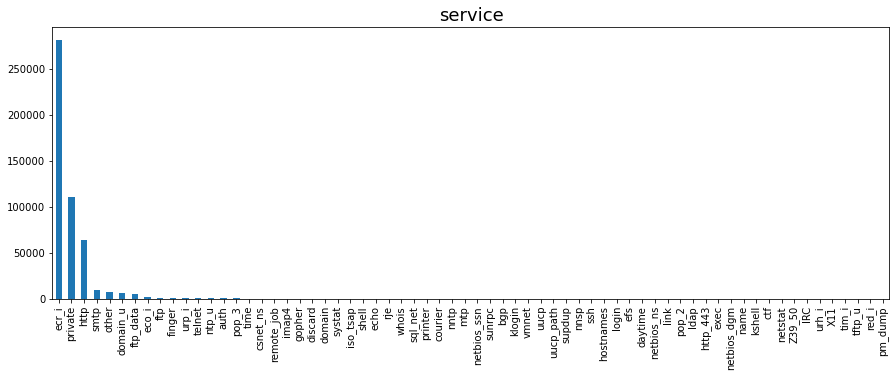

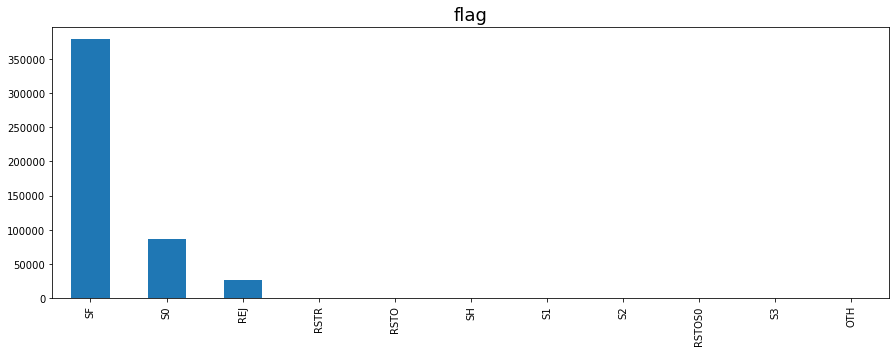

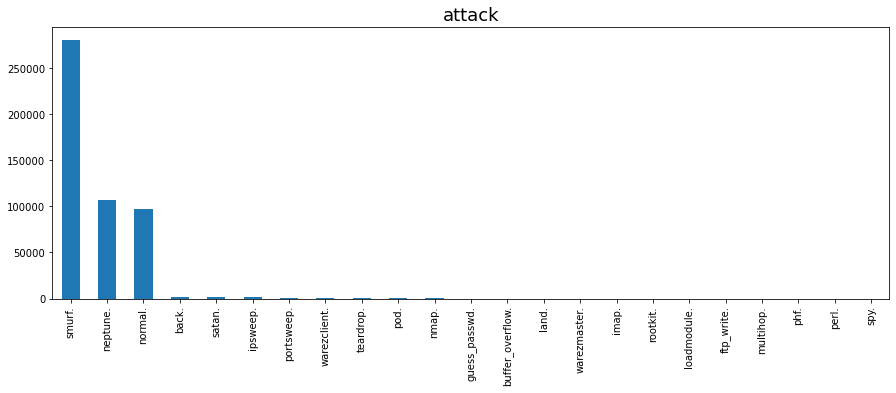

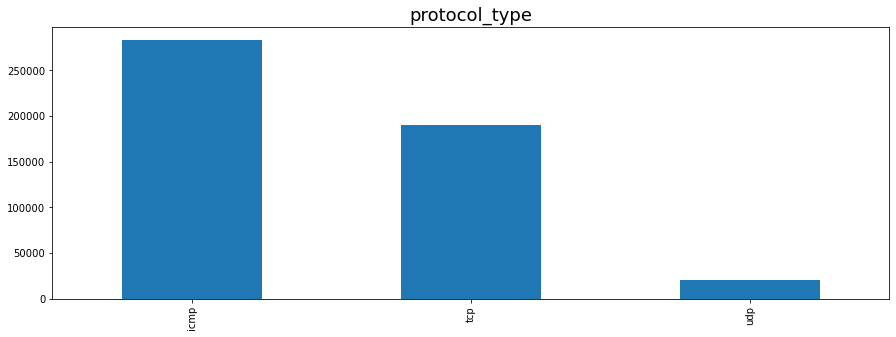

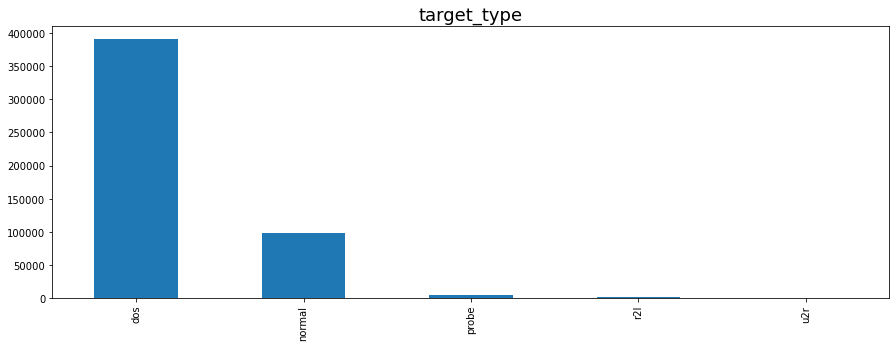

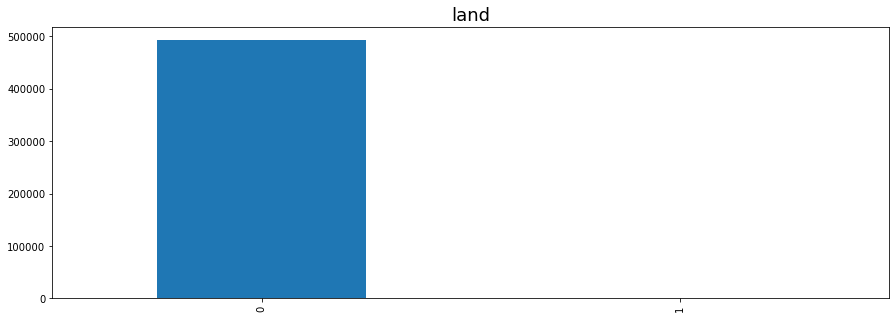

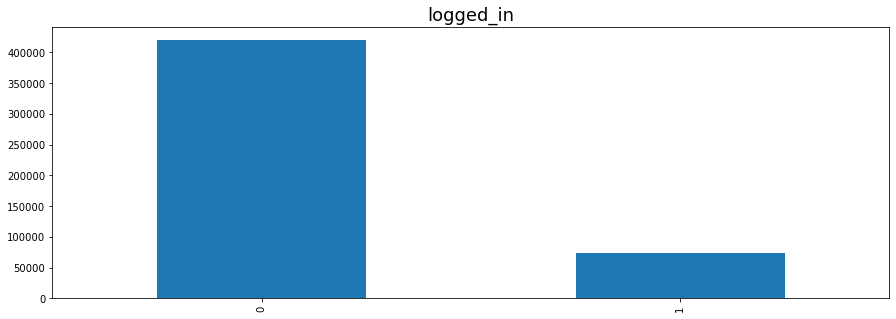

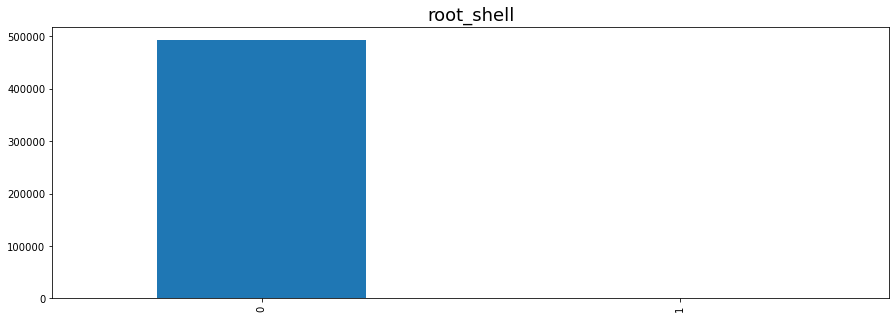

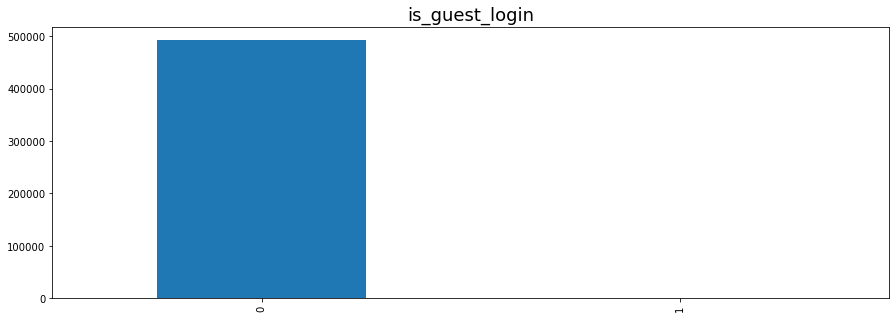

In [26]:
for i in categorical_cols:
    plot_dist(i)

### Explorar features numéricos

In [27]:
dataset.drop(categorical_cols, axis=1).describe().T

,count,mean,std,min,25%,50%,75%,max
duration,494021.0,47.979302,707.746472,0.0,0.00,0.0,0.00,58329.0
src_bytes,494021.0,3025.610296,988218.101050,0.0,45.00,520.0,1032.00,693375640.0
dst_bytes,494021.0,868.532425,33040.001252,0.0,0.00,0.0,0.00,5155468.0
wrong_fragment,494021.0,0.006433,0.134805,0.0,0.00,0.0,0.00,3.0
urgent,494021.0,0.000014,0.005510,0.0,0.00,0.0,0.00,3.0
hot,494021.0,0.034519,0.782103,0.0,0.00,0.0,0.00,30.0
num_failed_logins,494021.0,0.000152,0.015520,0.0,0.00,0.0,0.00,5.0
num_compromised,494021.0,0.010212,1.798326,0.0,0.00,0.0,0.00,884.0
su_attempted,494021.0,0.000036,0.007793,0.0,0.00,0.0,0.00,2.0
num_root,494021.0,0.011352,2.012718,0.0,0.00,0.0,0.00,993.0


### Verificar correlação

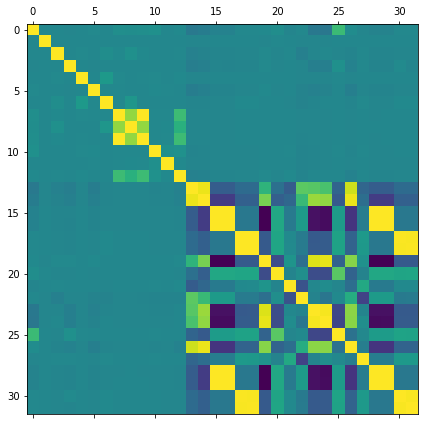

In [28]:
plt.figure(figsize=(7,7))
plt.matshow(dataset.drop(categorical_cols, axis=1).corr(), fignum=1);

`Existem muito valores com alta correlação. É possivel de serem retirados do dataset sem muitos problemas, pois não devem fazer muita difereça no accuraccy total, ale'm de baixar o tempo de treinamento. Retirar estes features é totalmente opcional, pois só aumantam o tempo de processamanto, o que neste caso (rede Neural simples, não fz muita diferença. `

## Normalizar features numericos

In [29]:
names_to_normalize = list(dataset.drop(categorical_cols, axis=1).columns)

In [30]:
min_max_scaler = preprocessing.MinMaxScaler()
data_scaled = dataset.copy(deep=True)
data_scaled[names_to_normalize] = min_max_scaler.fit_transform(
    dataset[names_to_normalize])

In [31]:
data_scaled.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,attack,target_type
0,0.0,tcp,http,SF,2.610418e-07,0.001057,0,0.0,0.0,0.0,...,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0,normal.,normal
1,0.0,tcp,http,SF,3.446905e-07,0.000094,0,0.0,0.0,0.0,...,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0,normal.,normal
2,0.0,tcp,http,SF,3.389216e-07,0.000259,0,0.0,0.0,0.0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
3,0.0,tcp,http,SF,3.158461e-07,0.000259,0,0.0,0.0,0.0,...,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0,normal.,normal
4,0.0,tcp,http,SF,3.129617e-07,0.000394,0,0.0,0.0,0.0,...,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0,normal.,normal


## Converter features categoricos em valores numéricos

In [32]:
def apply_dummies(df, feature):
    get_dummies = pd.get_dummies(df[feature])
    for x in get_dummies.columns:
        dummy_name = f"{feature}-{x}"
        df[dummy_name] = get_dummies[x]
    df.drop(feature, axis=1, inplace=True)
    return None

In [33]:
categorical_cols

['service',
 'flag',
 'attack',
 'protocol_type',
 'target_type',
 'land',
 'logged_in',
 'root_shell',
 'is_guest_login']

In [34]:
# apply one hot encoding for categorical columns except the target and target_types
for feature in categorical_cols:
    if feature not in ['attack', 'target_type']:
        apply_dummies(data_scaled, feature)

In [35]:
del data_scaled['attack']

In [36]:
data_scaled.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,...,protocol_type-tcp,protocol_type-udp,land-0,land-1,logged_in-0,logged_in-1,root_shell-0,root_shell-1,is_guest_login-0,is_guest_login-1
0,0.0,2.610418e-07,0.001057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,1,0,1,0
1,0.0,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,1,0,1,0
2,0.0,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,1,0,1,0
3,0.0,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,1,0,1,0
4,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,1,0,1,0


### Converter Target (target_type) em numérico

In [37]:
# Pega os valores unicos da coluna target 
attack_values = data_scaled.target_type.unique()

In [38]:
attack_values

array(['normal', 'u2r', 'dos', 'r2l', 'probe'], dtype=object)

In [39]:
# Transforma strings em numeros
attack_dict = dict(zip(attack_values, range(len(attack_values))))

In [40]:
attack_dict

{'normal': 0, 'u2r': 1, 'dos': 2, 'r2l': 3, 'probe': 4}

In [41]:
# Substitui os valores no dataset que sao string por numeros
data = data_scaled.replace({
    "target_type": attack_dict
})
data = data.apply(pd.to_numeric)

In [42]:
data.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,su_attempted,num_root,...,protocol_type-tcp,protocol_type-udp,land-0,land-1,logged_in-0,logged_in-1,root_shell-0,root_shell-1,is_guest_login-0,is_guest_login-1
0,0.0,2.610418e-07,0.001057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,1,0,1,0
1,0.0,3.446905e-07,0.000094,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,1,0,1,0
2,0.0,3.389216e-07,0.000259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,1,0,1,0
3,0.0,3.158461e-07,0.000259,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,1,0,1,0
4,0.0,3.129617e-07,0.000394,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1,0,1,0,0,1,1,0,1,0


In [43]:
data.shape

(494021, 121)

## Definir modelo e dataset de treino e teste

In [44]:
#Separa os dados entre treino e teste
train, test = np.split(data.sample(frac=1),
                       [int(TRAIN_PERCENTAGE * len(data))])

In [45]:
train.shape, test.shape

((395216, 121), (98805, 121))

In [46]:
train_samples = train.drop(['target_type'], axis=1)
train_labels = to_categorical(
    train[['target_type']].to_numpy(), num_classes=len(attack_values))
test_samples = test.drop(['target_type'], axis=1)
test_labels = to_categorical(test[['target_type']].to_numpy(), num_classes=len(attack_values))

In [47]:
train_labels.shape

(395216, 5)

In [48]:
input_shape = (train_samples.shape[1],)
input_shape

(120,)

## Definir modelo basico - 1 Node / 1Layer

In [49]:
sgd = optimizers.SGD(lr=LEARNING_RATE)

In [50]:
# Criacao do modelo
model = Sequential ([
Dense(1, input_shape=input_shape , activation=ACTIVATION_FN),
Dense(len(attack_values), activation='softmax'), ])

In [51]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 1)                 121       
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 10        
Total params: 131
Trainable params: 131
Non-trainable params: 0
_________________________________________________________________


In [52]:
 model.compile(
     optimizer=sgd,
     loss='categorical_crossentropy',
     metrics=['accuracy'])

### Treinamento e teste do modelo basico  (SGR - Sem def. Batches)

In [54]:
start_time = time.time()

history = model.fit(x=train_samples,
                    y=train_labels,
                    epochs=EPOCHS,
                    validation_data=(test_samples, test_labels),
                    verbose=VERBOSE)
end_time = time.time()

Epoch 1/200
12351/12351 [==============================] - 7s 590us/step - loss: 0.1633 - accuracy: 0.9667 - val_loss: 0.0814 - val_accuracy: 0.9818
Epoch 2/200
12351/12351 [==============================] - 7s 561us/step - loss: 0.0747 - accuracy: 0.9829 - val_loss: 0.0704 - val_accuracy: 0.9833
Epoch 3/200
12351/12351 [==============================] - 7s 561us/step - loss: 0.0676 - accuracy: 0.9836 - val_loss: 0.0657 - val_accuracy: 0.9835
Epoch 4/200
12351/12351 [==============================] - 7s 564us/step - loss: 0.0639 - accuracy: 0.9838 - val_loss: 0.0629 - val_accuracy: 0.9836
Epoch 5/200
12351/12351 [==============================] - 7s 563us/step - loss: 0.0615 - accuracy: 0.9839 - val_loss: 0.0609 - val_accuracy: 0.9838
Epoch 6/200
12351/12351 [==============================] - 7s 563us/step - loss: 0.0598 - accuracy: 0.9840 - val_loss: 0.0594 - val_accuracy: 0.9837
Epoch 7/200
12351/12351 [==============================] - 7s 564us/step - loss: 0.0584 - accuracy: 0.9840

Epoch 56/200
12351/12351 [==============================] - 8s 653us/step - loss: 0.0365 - accuracy: 0.9861 - val_loss: 0.0369 - val_accuracy: 0.9881
Epoch 57/200
12351/12351 [==============================] - 8s 655us/step - loss: 0.0362 - accuracy: 0.9863 - val_loss: 0.0364 - val_accuracy: 0.9858
Epoch 58/200
12351/12351 [==============================] - 8s 648us/step - loss: 0.0360 - accuracy: 0.9864 - val_loss: 0.0363 - val_accuracy: 0.9857
Epoch 59/200
12351/12351 [==============================] - 8s 631us/step - loss: 0.0357 - accuracy: 0.9866 - val_loss: 0.0359 - val_accuracy: 0.9859
Epoch 60/200
12351/12351 [==============================] - 8s 656us/step - loss: 0.0355 - accuracy: 0.9869 - val_loss: 0.0363 - val_accuracy: 0.9883
Epoch 61/200
12351/12351 [==============================] - 8s 654us/step - loss: 0.0353 - accuracy: 0.9870 - val_loss: 0.0357 - val_accuracy: 0.9885
Epoch 62/200
12351/12351 [==============================] - 8s 640us/step - loss: 0.0350 - accuracy:

12351/12351 [==============================] - 8s 618us/step - loss: 0.0297 - accuracy: 0.9930 - val_loss: 0.0306 - val_accuracy: 0.9921
Epoch 111/200
12351/12351 [==============================] - 8s 618us/step - loss: 0.0297 - accuracy: 0.9929 - val_loss: 0.0303 - val_accuracy: 0.9927
Epoch 112/200
12351/12351 [==============================] - 7s 599us/step - loss: 0.0297 - accuracy: 0.9931 - val_loss: 0.0305 - val_accuracy: 0.9926
Epoch 113/200
12351/12351 [==============================] - 8s 613us/step - loss: 0.0296 - accuracy: 0.9932 - val_loss: 0.0303 - val_accuracy: 0.9926
Epoch 114/200
12351/12351 [==============================] - 7s 596us/step - loss: 0.0296 - accuracy: 0.9932 - val_loss: 0.0303 - val_accuracy: 0.9930
Epoch 115/200
12351/12351 [==============================] - 7s 607us/step - loss: 0.0295 - accuracy: 0.9932 - val_loss: 0.0305 - val_accuracy: 0.9934
Epoch 116/200
12351/12351 [==============================] - 7s 603us/step - loss: 0.0294 - accuracy: 0.9933

12351/12351 [==============================] - 7s 602us/step - loss: 0.0280 - accuracy: 0.9944 - val_loss: 0.0287 - val_accuracy: 0.9948
Epoch 165/200
12351/12351 [==============================] - 8s 615us/step - loss: 0.0281 - accuracy: 0.9944 - val_loss: 0.0298 - val_accuracy: 0.9932
Epoch 166/200
12351/12351 [==============================] - 8s 619us/step - loss: 0.0280 - accuracy: 0.9944 - val_loss: 0.0290 - val_accuracy: 0.9942
Epoch 167/200
12351/12351 [==============================] - 7s 607us/step - loss: 0.0280 - accuracy: 0.9944 - val_loss: 0.0289 - val_accuracy: 0.9944
Epoch 168/200
12351/12351 [==============================] - 8s 616us/step - loss: 0.0280 - accuracy: 0.9943 - val_loss: 0.0288 - val_accuracy: 0.9944
Epoch 169/200
12351/12351 [==============================] - 8s 615us/step - loss: 0.0280 - accuracy: 0.9946 - val_loss: 0.0294 - val_accuracy: 0.9938
Epoch 170/200
12351/12351 [==============================] - 8s 612us/step - loss: 0.0279 - accuracy: 0.9945

In [55]:
# Teste do modelo
h2 = model.evaluate(
x=test_samples , y=test_labels , verbose=VERBOSE ,
)

3088/3088 [==============================] - 2s 503us/step - loss: 0.0290 - accuracy: 0.9939


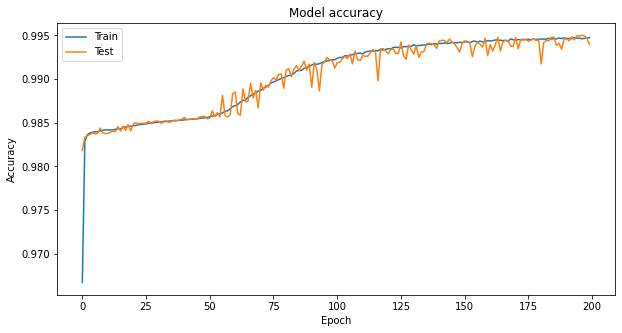

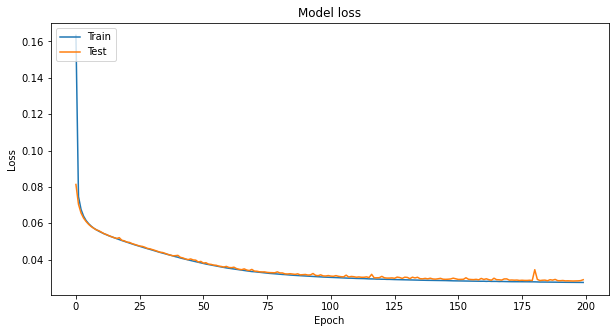

In [56]:
# plot_model(model, to_file=’model.png’)
# Plot training & validation accuracy values
plt.figure(figsize=(10,5))
plt.plot(history.history['accuracy']) 
plt.plot(history.history['val_accuracy']) 
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.figure(figsize=(10,5)) 
plt.plot(history.history['loss']) 
plt.plot(history.history['val_loss'])
plt.title('Model loss') 
plt.ylabel('Loss') 
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left') 
plt.show()

Minimum Validation Loss: 0.0283


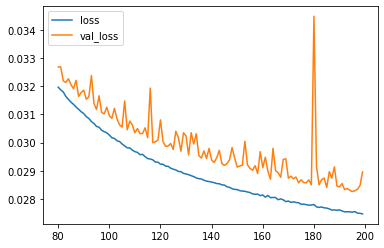

In [57]:
# Abrir um pouco o gráfico
history_df = pd.DataFrame(history.history)
history_df.loc[80:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

`Uma única camada e um único nó parece que leva o modelo a "Underfitting", pois o gap entre as curvas é muito pequena e a curva de validation-loss nunca "sobe". Em relação ao tempo, demorou muito (Aprox. 26'), pois os dados eram utilizados um a um em vez de em batches.`

### Treinamento do modelo básico, incluindo Batch

In [66]:
# vamos analisar os gráficos, então não será necessário ver resultados epoch por epoch 
VERBOSE=0

In [67]:
model = Sequential([
    Dense(1, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(len(attack_values), activation='softmax'), ])

In [68]:
model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [69]:
start_time = time.time()

history = model.fit(x=train_samples,
                    y=train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    validation_data=(test_samples, test_labels))
end_time = time.time()

In [73]:
# Teste do modelo
h2 = model.evaluate(
    x=test_samples,
    y=test_labels,
    verbose=1,
)

3088/3088 [==============================] - 1s 447us/step - loss: 0.0598 - accuracy: 0.9840


In [76]:
print("Tempo de treinamento: {}s".format(round(end_time-start_time)))

Tempo de treinamento: 83s


In [77]:
def plot_train_val_accuracy_loss(history):
    plt.figure(figsize=(10,5))
    plt.plot(history.history['accuracy']) 
    plt.plot(history.history['val_accuracy']) 
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

    # Plot training & validation loss values
    plt.figure(figsize=(10,5)) 
    plt.plot(history.history['loss']) 
    plt.plot(history.history['val_loss'])
    plt.title('Model loss') 
    plt.ylabel('Loss') 
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left') 
    plt.show()

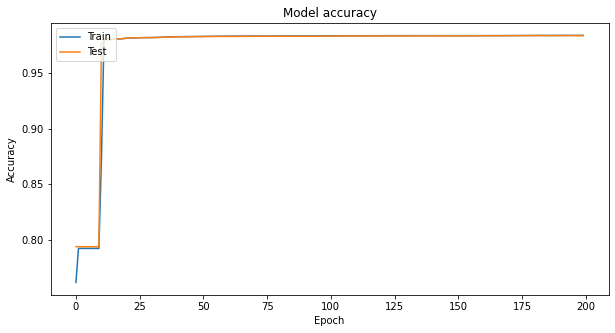

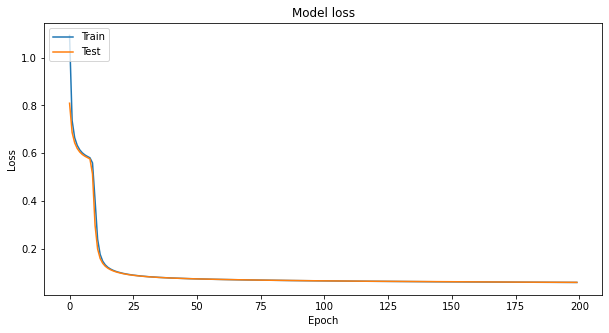

In [78]:
plot_train_val_accuracy_loss(history)

`Apesar de muito mais rápido (o modelo levou apenas 83s, claramante houve underfitting.`

## Treinar modelo com mais nós

In [79]:
model = Sequential([
    Dense(128, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(len(attack_values), activation='softmax'), ])

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [80]:
start_time = time.time()

history = model.fit(x=train_samples,
                    y=train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    validation_data=(test_samples, test_labels))
end_time = time.time()
print("Tempo de treinamento: {}s".format(round(end_time-start_time)))

Tempo de treinamento: 136s


In [81]:
# Teste do modelo
h2 = model.evaluate(
    x=test_samples,
    y=test_labels,
    verbose=1,
)

3088/3088 [==============================] - 1s 468us/step - loss: 0.0200 - accuracy: 0.9941


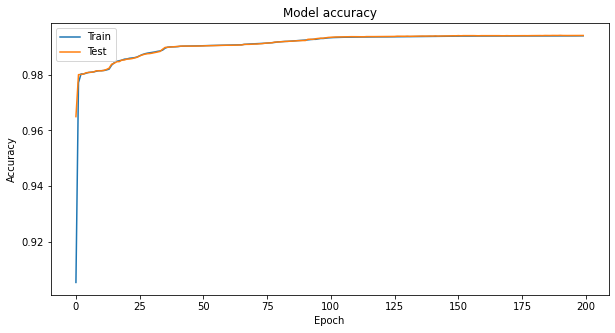

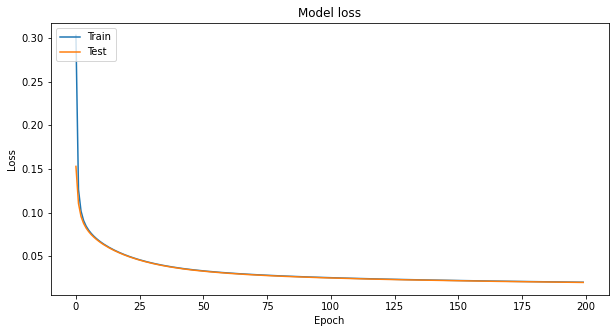

In [82]:
plot_train_val_accuracy_loss(history)

`Uma única camada mesmo de muitos nós parece que leva o modelo a "Underfitting", pois o gap entre as curvas é muito pequena e a curva de validation-loss nunca "sobe"`

## Treinar modelo com mais camadas

In [84]:
model = Sequential([
    Dense(128, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(1, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(len(attack_values), activation='softmax'), ])

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_11 (Dense)             (None, 128)               15488     
_________________________________________________________________
dense_12 (Dense)             (None, 1)                 129       
_________________________________________________________________
dense_13 (Dense)             (None, 5)                 10        
Total params: 15,627
Trainable params: 15,627
Non-trainable params: 0
_________________________________________________________________


In [85]:
start_time = time.time()

history = model.fit(x=train_samples,
                    y=train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    validation_data=(test_samples, test_labels))
end_time = time.time()
print("Tempo de treinamento: {}s".format(round(end_time-start_time)))

Tempo de treinamento: 139s


In [86]:
# Teste do modelo
h2 = model.evaluate(
    x=test_samples,
    y=test_labels,
    verbose=1,
)

3088/3088 [==============================] - 1s 440us/step - loss: 0.4817 - accuracy: 0.7981


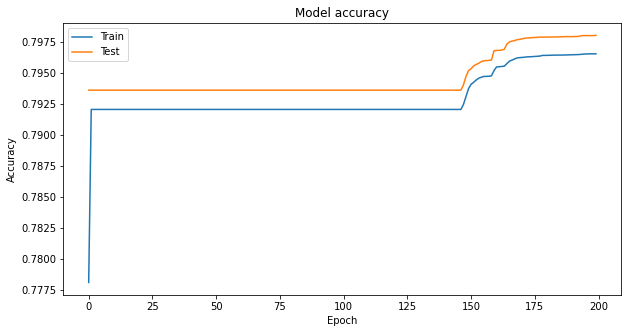

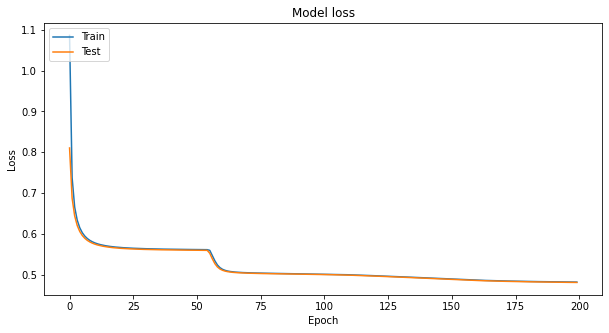

In [87]:
plot_train_val_accuracy_loss(history)

Minimum Validation Loss: 0.4817


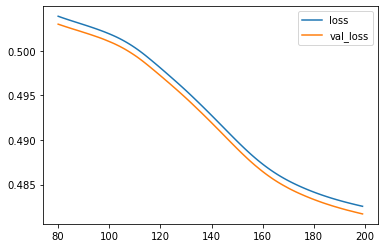

In [88]:
# Abrir um pouco o gráfico
history_df = pd.DataFrame(history.history)
history_df.loc[80:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

`Uma camada adicional mesmo com 1 nó somente parece que resolveu o problema de "Underfitting". Vamos verificar com mais nós.`

In [89]:
model = Sequential([
    Dense(128, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(128, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(len(attack_values), activation='softmax'), ])

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_14 (Dense)             (None, 128)               15488     
_________________________________________________________________
dense_15 (Dense)             (None, 128)               16512     
_________________________________________________________________
dense_16 (Dense)             (None, 5)                 645       
Total params: 32,645
Trainable params: 32,645
Non-trainable params: 0
_________________________________________________________________


In [90]:
start_time = time.time()

history = model.fit(x=train_samples,
                    y=train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    validation_data=(test_samples, test_labels))
end_time = time.time()
print("Tempo de treinamento: {}s".format(round(end_time-start_time)))

Tempo de treinamento: 241s


In [91]:
# Teste do modelo
h2 = model.evaluate(
    x=test_samples,
    y=test_labels,
    verbose=1,
)

3088/3088 [==============================] - 2s 667us/step - loss: 0.0118 - accuracy: 0.9959


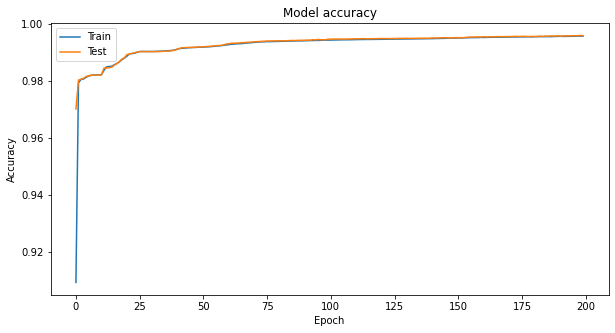

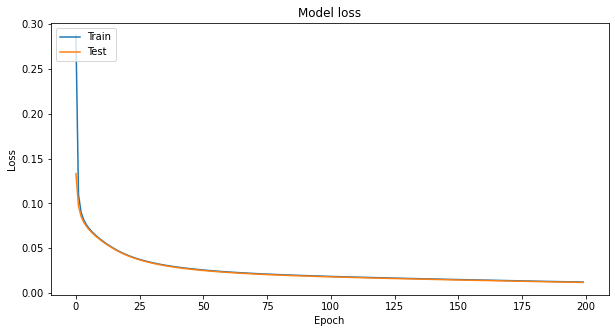

In [92]:
plot_train_val_accuracy_loss(history)

Minimum Validation Loss: 0.0118


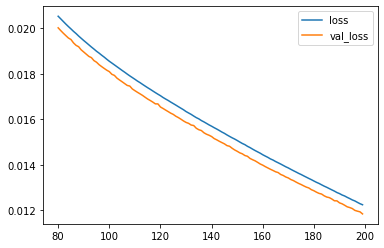

In [93]:
# Abrir um pouco o gráfico
history_df = pd.DataFrame(history.history)
history_df.loc[80:, ['loss', 'val_loss']].plot()
print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

`Existe um claro problema aqui. Validation Loss é menor que o Training loss. Muito provavelmente é porque os dados de validação não são representativos (Dados de validação são "mais fáceis" que os de treinamento (ver Aurélien Geron twitter: https://twitter.com/aureliengeron/status/1110839223878184960). Lembre-se que havia um desbalanceamanto muito grande de classes. Talvez outros métodos devam ser utilizados para separar train e validation.`

### Tentar aumentar número de Epocas

In [96]:
EPOCHS = 1000

In [95]:
model = Sequential([
    Dense(128, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(128, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(len(attack_values), activation='softmax'), ])

model.compile(optimizer=sgd,
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [97]:
start_time = time.time()

history = model.fit(x=train_samples,
                    y=train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    validation_data=(test_samples, test_labels))
end_time = time.time()
print("Tempo de treinamento: {}s".format(round(end_time-start_time)))

Tempo de treinamento: 1291s


3088/3088 [==============================] - 2s 709us/step - loss: 0.0034 - accuracy: 0.9992


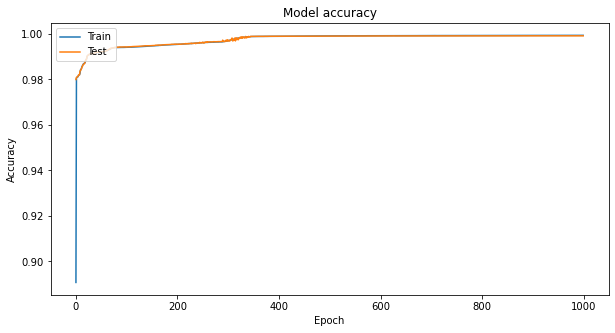

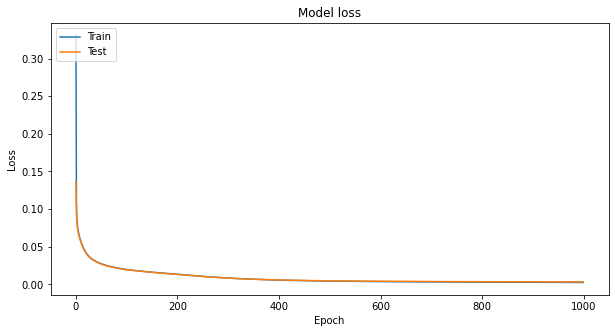

In [98]:
# Teste do modelo
h2 = model.evaluate(
    x=test_samples,
    y=test_labels,
    verbose=1,
)

plot_train_val_accuracy_loss(history)

In [114]:
# Abrir um pouco o gráfico
def zoom_loss_graph(history, start=80):
    history_df = pd.DataFrame(history.history)
    history_df.loc[start:, ['loss', 'val_loss']].plot()
    print("Minimum Validation Loss: {:0.4f}".format(history_df['val_loss'].min()));

Minimum Validation Loss: 0.0034


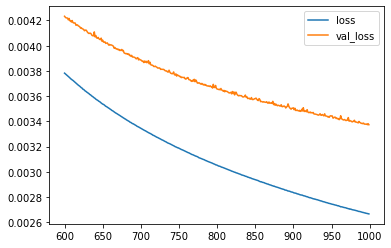

In [103]:
zoom_loss_graph(history, start=600)

`Pelo menos aumentando-se o número de épocas a perda (loss) de validação fica um pouco maior que a de treinamento. O problema é que tanto loss, quanto val_loss continuam caindo. Talvez seja necessário diminuir o Learning-Rate, ou mudar o optimizador. Tentemos direto com o Adam que é o melhor, mas no modelo com um unico Nó na camada oculta.`

### Testar com o optimizer 'Adam' 

In [107]:
EPOCHS = 200

In [108]:
model = Sequential([
    Dense(128, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(1, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(len(attack_values), activation='softmax'), ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_10"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_26 (Dense)             (None, 128)               15488     
_________________________________________________________________
dense_27 (Dense)             (None, 1)                 129       
_________________________________________________________________
dense_28 (Dense)             (None, 5)                 10        
Total params: 15,627
Trainable params: 15,627
Non-trainable params: 0
_________________________________________________________________


In [109]:
start_time = time.time()

history = model.fit(x=train_samples,
                    y=train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    validation_data=(test_samples, test_labels))
end_time = time.time()
print("Tempo de treinamento: {}s".format(round(end_time-start_time)))

Tempo de treinamento: 162s


3088/3088 [==============================] - 2s 561us/step - loss: 0.0075 - accuracy: 0.9992


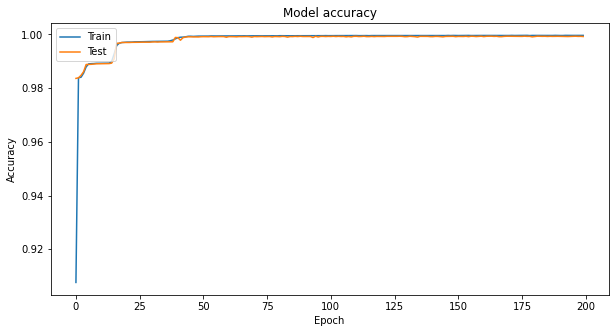

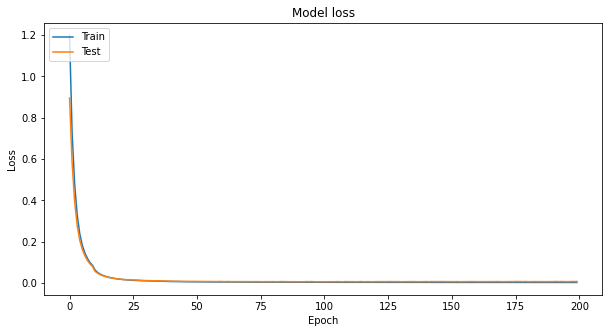

In [110]:
# Teste do modelo
h2 = model.evaluate(
    x=test_samples,
    y=test_labels,
    verbose=1,
)

plot_train_val_accuracy_loss(history)

Minimum Validation Loss: 0.0060


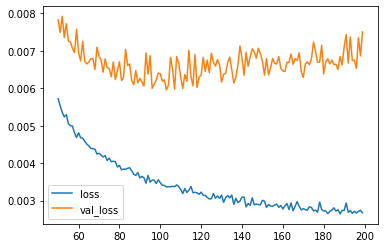

In [115]:
# Abrir um pouco o gráfico
zoom_loss_graph(history, start=50)

`Com apenas 1 nó na camada intermediária e trocando o otimizador para 'adam', se observa que o erro de validação é ligeiramente maior que o treinamento (o que é bom). Parece também que a perda depois da epoca 100 começa a aumantar, o que sugere um overfitting. Deve-se treinar o modelo novamente com menos épocas ou utilizando-se "early stopping". `

### Treinar com menos epocas

In [116]:
early_stopping = callbacks.EarlyStopping(
    min_delta=0.001, # minimium amount of change to count as an improvement
    patience=20, # how many epochs to wait before stopping
    restore_best_weights=True,
)

In [117]:
# valor máximo para epocas. Não deveria ser atingido
EPOCHS = 200

In [118]:
model = Sequential([
    Dense(128, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(1, input_shape=input_shape, activation=ACTIVATION_FN),
    Dense(len(attack_values), activation='softmax'), ])

model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

Model: "sequential_11"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_29 (Dense)             (None, 128)               15488     
_________________________________________________________________
dense_30 (Dense)             (None, 1)                 129       
_________________________________________________________________
dense_31 (Dense)             (None, 5)                 10        
Total params: 15,627
Trainable params: 15,627
Non-trainable params: 0
_________________________________________________________________


In [120]:
start_time = time.time()

history = model.fit(x=train_samples,
                    y=train_labels,
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS,
                    verbose=VERBOSE,
                    validation_data=(test_samples, test_labels))
end_time = time.time()
print("Tempo de treinamento: {}s".format(round(end_time-start_time)))

Tempo de treinamento: 153s


3088/3088 [==============================] - 1s 485us/step - loss: 0.0053 - accuracy: 0.9993


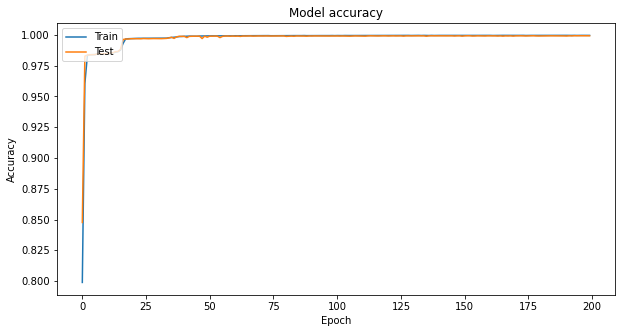

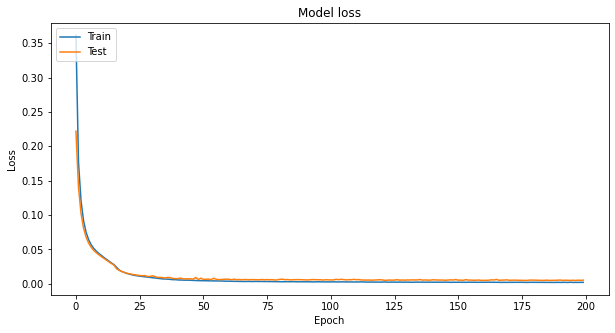

In [121]:
# Teste do modelo
h2 = model.evaluate(
    x=test_samples,
    y=test_labels,
    verbose=1,
)

plot_train_val_accuracy_loss(history)

Minimum Validation Loss: 0.0048


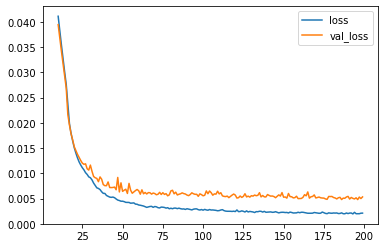

In [124]:
# Abrir um pouco o gráfico
zoom_loss_graph(history, start=10)

`Com apenas 1 nó na camada intermediária e trocando o otimizador para 'adam', se observa que o erro de validação é ligeiramente maior que o treinamento (o que é bom). Como o modelo foi novamante inicializado com valores randomicos, desta vez observe que a perda não sobe a partir de 100 épocas, logo o "early stopping" não chegou a atuar. Mas este modelo parece muito bom. Vamos parar por aqui. `

## Salvar modelo

In [125]:
model.save('model.h5')

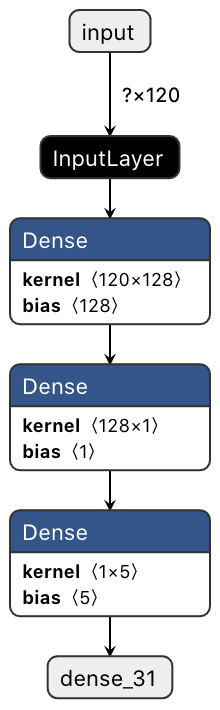